In [1]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import math
import sys
%matplotlib inline

In [2]:
# Load the data
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)

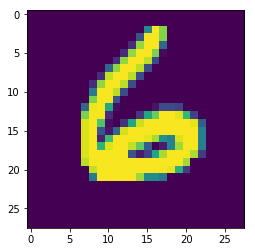

In [3]:
# Example of a picture
plt.imshow(train['data'][15].reshape(28,28))

In [4]:
np.random.seed(7)

# Set labels (1 if "five" and 0 if "six")
data_set = train['data']
labels = train['labels'] == 5 + 0

train_numbers = np.arange(10000)
np.random.shuffle(train_numbers)

# Pick 90% of dataset for training set
X_train = data_set[train_numbers[:9000:]]
Y_train = labels[train_numbers[:9000:]]

# Pick 10% of dataset for test set
X_test = data_set[train_numbers[9000::]]
Y_test = labels[train_numbers[9000::]]

In [5]:
def sigmoid(z):
    """
    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

In [6]:
def initialize_with_zeros(dim):
    """
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    w = np.zeros((dim, 1))
    b = 0
    return w, b

In [7]:
def forward_prop(w, b, X, Y, lambd):
    """
    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- dataset
    Y -- true "label" vector (containing 0 if "five", 1 if "six") of size (1, number of examples)

    Return:
    cost -- cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    lambd -- regularization hyperparameter, scalar
    """
    
    m = X.shape[1]
    
    z = np.dot(w.T, X) + b
    A = sigmoid(z) 
    
    cost = (-1 / m) * (np.dot(Y, np.log(A.T + 1e-16)) + np.dot((1 - Y) , np.log (1 - A.T + 1e-16))) + lambd/(2*m)*np.dot(w.T, w)
    dw = 1/m * np.dot(X , (A - Y).T) + w*(lambd)/m
    db = 1/m * np.sum (A - Y)
        
    grads = {"dw": dw,
             "db": db}
        
    return grads, cost  

In [8]:
def optimize(w, b, X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, lambd = 0, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array
    
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    lambd -- regularization hyperparameter, scalar
    print_cost -- True to print the loss every 250 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    accur -- list of all the accuracy computed during the optimization, this will be used to plot the accuracy curve
    """
    
    dim = Y_train.shape[0]
    
    costs = dict()
    costs["train"] = list()
    costs["test"]  = list()
    
    accur = dict()
    accur["train"] = list()
    accur["test"]  = list()
    
    for i in range(num_iterations):
        
        grads, cost_train = forward_prop(w, b, X_train, Y_train, lambd)
       
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
       
        if i % 100 == 0:
            _, cost_test = forward_prop(w,b, X_test, Y_test, lambd)
            costs["train"].append(cost_train)
            costs["test"].append(cost_test)
            
            Y_prediction_test = predict(w, b, X_test)
            Y_prediction_train = predict(w, b, X_train)
            accur["train"].append(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100)
            accur["test"].append(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100)                                    
                                         
        if print_cost and i % 250 == 0:
            print ("Test cost after iteration %i: %f" %(i, cost_test))
            print ("Train cost after iteration %i: %f" %(i, cost_train))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, accur

In [9]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array
    b -- bias, a scalar
    X -- data set
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    z = np.dot(w.T, X) + b
    A = sigmoid(z)  
    
    Y_prediction = np.around(A) 
    return Y_prediction

In [10]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, lambd = 0, print_cost = False):
    """
    Arguments:
    X_train -- training set represented by a numpy array
    Y_train -- training labels represented by a numpy array
    X_test -- test set represented by a numpy array
    Y_test -- test labels represented by a numpy array
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    lambd -- regularization hyperparameter, scalar
    print_cost -- Set to true to print the cost every 250 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
   
    dim = X_train.shape[0]
    w, b = initialize_with_zeros(dim)

    parameters, grads, costs, accur = optimize(w, b, X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, lambd, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "accur": accur,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [25]:
d = model(X_train.T, Y_train.T, X_test.T, Y_test.T, num_iterations = 10000, learning_rate = 0.00005,lambd=0, print_cost = True)

Test cost after iteration 0: 0.727356
Train cost after iteration 0: 0.693147
Test cost after iteration 250: 0.049158
Train cost after iteration 250: 0.047494
Test cost after iteration 500: 0.041533
Train cost after iteration 500: 0.042003
Test cost after iteration 750: 0.039238
Train cost after iteration 750: 0.039017
Test cost after iteration 1000: 0.036861
Train cost after iteration 1000: 0.036921
Test cost after iteration 1250: 0.035671
Train cost after iteration 1250: 0.035308
Test cost after iteration 1500: 0.034239
Train cost after iteration 1500: 0.034000
Test cost after iteration 1750: 0.033448
Train cost after iteration 1750: 0.032900
Test cost after iteration 2000: 0.032439
Train cost after iteration 2000: 0.031954
Test cost after iteration 2250: 0.031856
Train cost after iteration 2250: 0.031125
Test cost after iteration 2500: 0.031086
Train cost after iteration 2500: 0.030389
Test cost after iteration 2750: 0.030631
Train cost after iteration 2750: 0.029729
Test cost after 

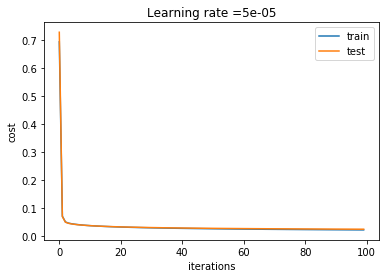

In [31]:
# Plot learning curve
plt.plot(np.squeeze(d['costs']['train']))
plt.plot(np.squeeze(d['costs']['test']))

plt.legend(['train', 'test'], loc='upper right')

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

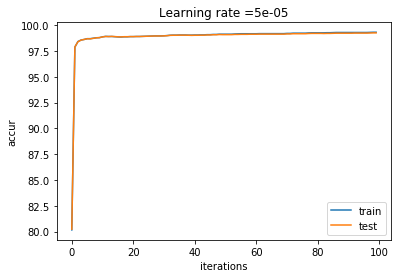

In [32]:
# Plot accuracy curve
plt.plot(np.squeeze(d['accur']['train']))
plt.plot(np.squeeze(d['accur']['test']))

plt.legend(['train', 'test'], loc='lower right')

plt.ylabel('accur')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [33]:
X = test_no_lables['data'].T

# Convert to probobillity of "six"
Y_pred = 1 - sigmoid(np.dot(d["w"].T, X) + d["b"])

# Save results
with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(len(test_no_lables['data'])):
        print(i, np.squeeze(Y_pred[:, i]), sep=',', file=fout)

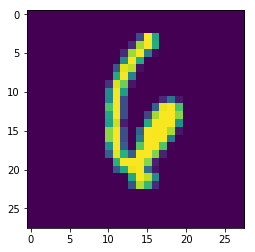

In [37]:
plt.imshow(test_no_lables['data'][228].reshape(28,28))

In [78]:
np.random.seed(0)
train_numbers = np.arange(1000)
np.random.shuffle(train_numbers)

X_test = data_set[train_numbers]
Y_test = labels[train_numbers]
Y_prediction_train = predict(d["w"], d["b"], X_test.T)

print("Overall accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_test)) * 100))

Overall accuracy: 99.2 %
